Dieses Notebook erzeugt eine Grafik, die die vier verschiedenen Ausschnitte der EEG Daten und Annotationen zeigt.

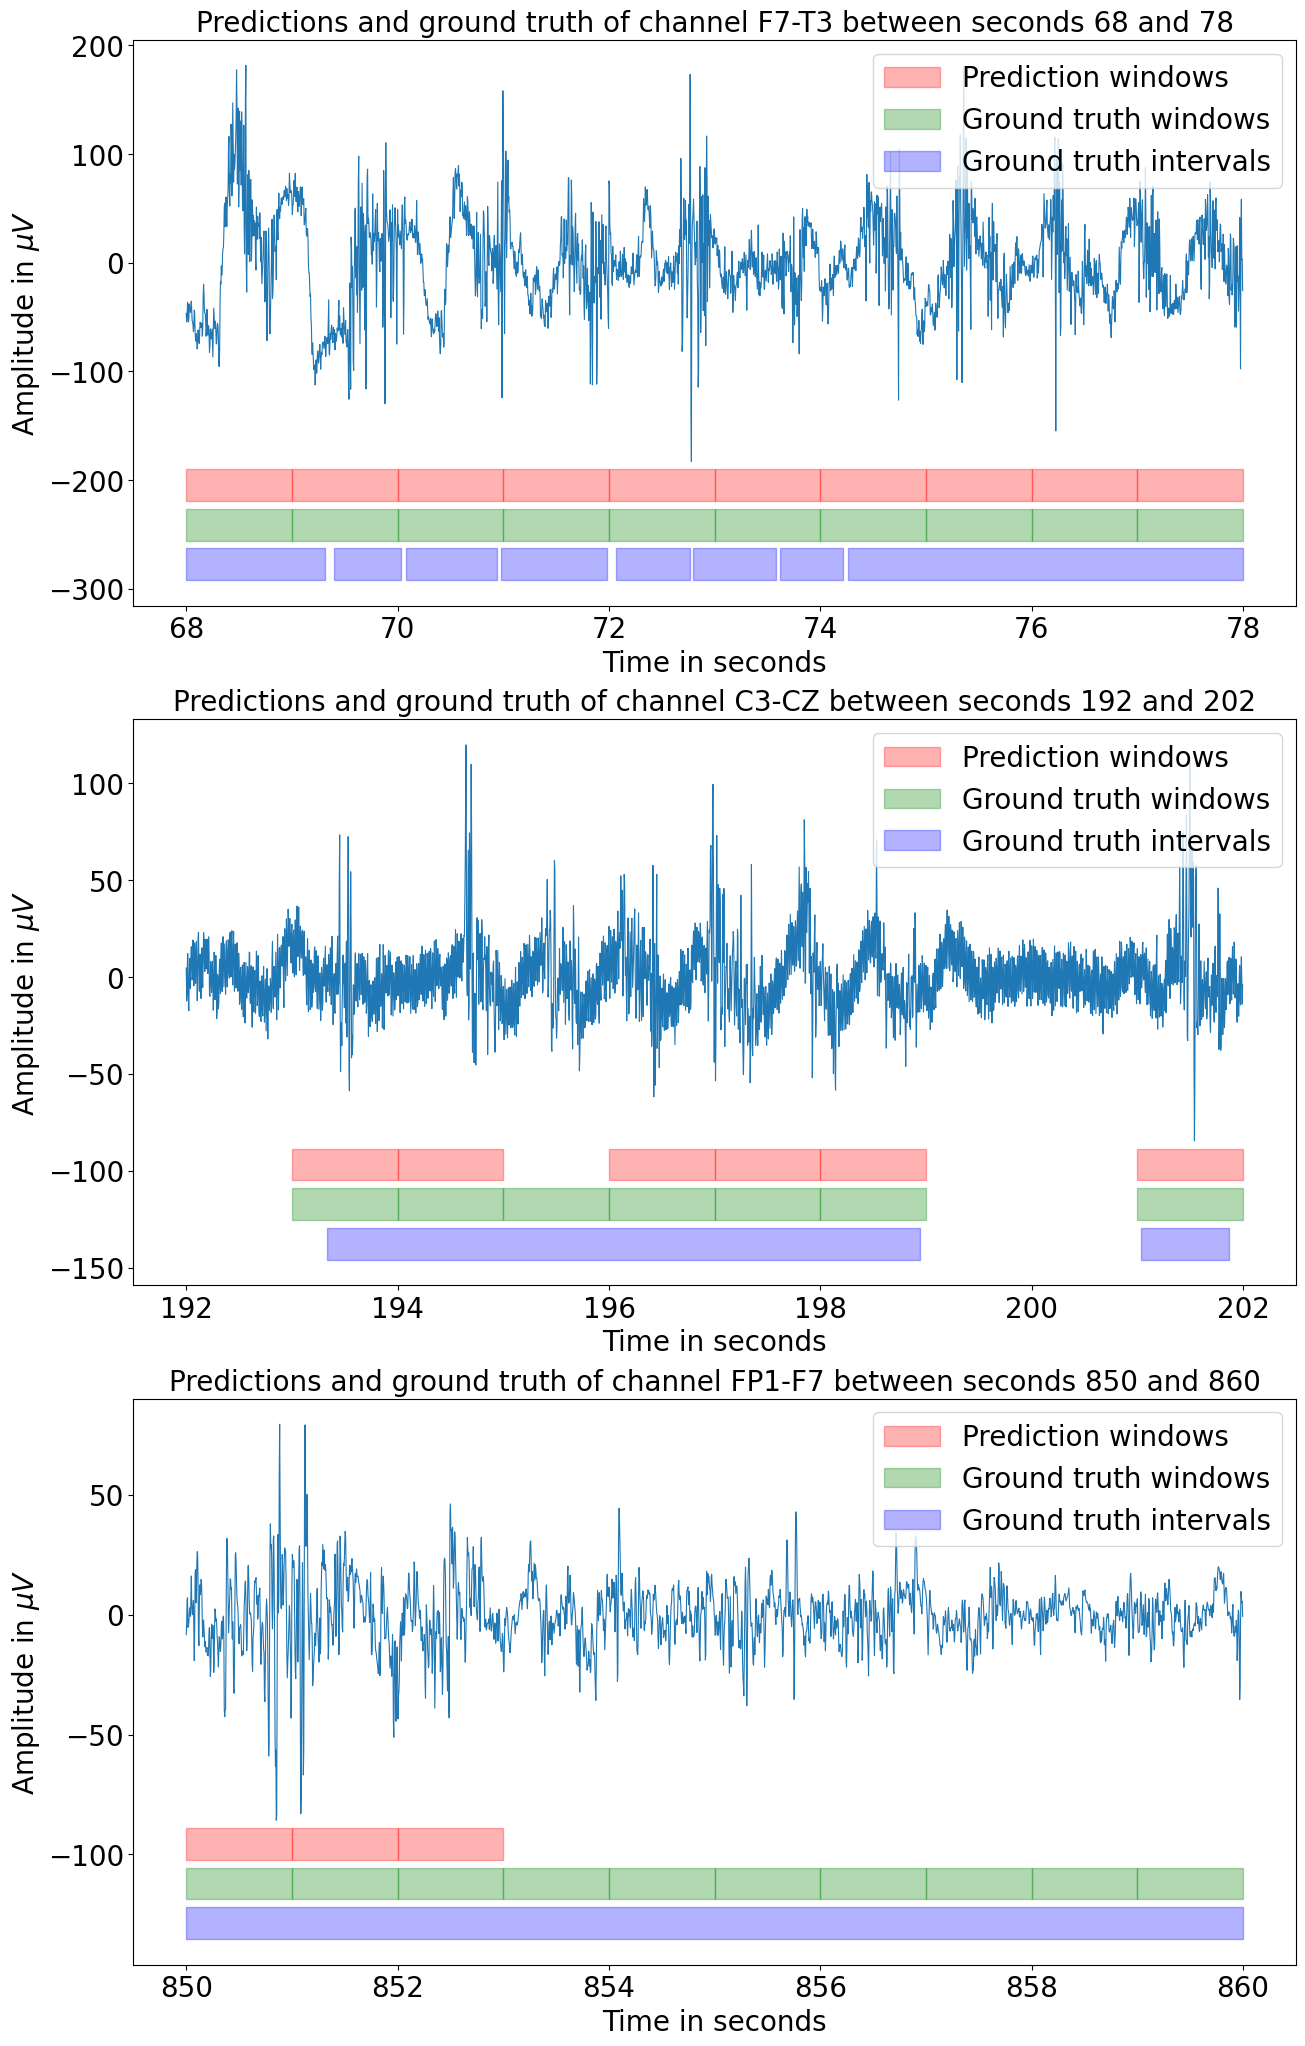

In [1]:
import sys
sys.path.append('../03 - Training')

import h5py
import numpy as np
import pyedflib
import os
from utils.visualization import visualize_model_predictions
import joblib
from matplotlib import pyplot as plt

dataset_path = '../../../../tuar_processed'
feature_file = '../03 - Training/features/features.hdf5'
# recordings = ['aaaaadmi_s012_t005', 'aaaaadmi_s012_t005', 'aaaaaovl_s001_t000', 'aaaaaovl_s001_t000']
# channels = ['F7-T3', 'C3-CZ', 'F7-T3', 'FP1-F7']
# intervals = [(68, 78), (192, 202), (80, 90), (1000, 1010)]
recordings = ['aaaaadmi_s012_t005', 'aaaaadmi_s012_t005', 'aaaaaovl_s001_t000']
channels = ['F7-T3', 'C3-CZ', 'FP1-F7']
intervals = [(68, 78), (192, 202), (850, 860)]
model_path = '../03 - Training/models/07-12-25 13-44-13.joblib'
importance_path = '../03 - Training/output/exp_03_12_feature_importance.joblib'

importance = joblib.load(importance_path)

top_n_features = 25
top_n_features_idx = np.flip(np.argsort(importance['importances_mean']))[:top_n_features]

fig, axes = plt.subplots(3, 1,figsize=(15, 25))

for recording, channel, (start, stop), ax in zip(recordings, channels, intervals, axes.flat):
    with h5py.File(feature_file) as f:
        channel_group = f[recording][channel]
        feature_vector_list = []
        features = [feat for feat in channel_group.keys() if not feat.startswith('labels')]
        for feature in features:
            feature_vector_list.append(channel_group[feature][:])
        feature_matrix = np.column_stack(feature_vector_list)
        feature_matrix = feature_matrix[:, top_n_features_idx]
        y_true = channel_group['labels'][:]

    recording_edf = recording + '.edf'

    for root, dirs, files in os.walk(dataset_path):
        if recording_edf not in files:
            continue

        recording_edf_path = os.path.join(root, recording_edf)
        with pyedflib.EdfReader(recording_edf_path) as reader:
            channel_data = reader.readSignal(reader.getSignalLabels().index(channel))
            split = os.path.basename(root)

    clf = joblib.load(model_path)

    y_pred = clf.predict(feature_matrix)
    ax = visualize_model_predictions(ax, channel_data, y_true, y_pred, start, stop, os.path.join(dataset_path, split, recording + '.csv'), channel)

fig.savefig('output/exp_04_03_prediction_visualization.pdf', bbox_inches='tight')
fig.show()